# Model Selection

[Resource](https://harvard-iacs.github.io/2018-CS109A/sections/section-4/demo/)

In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

import itertools

from IPython.display import display
pd.set_option("display.max_columns", 999)
pd.set_option("display.width", 500)
sns.set_style("whitegrid")
sns.set_context("talk")

# NYC Car Hire Dataset

Welp... here we are again. This data requires a request for access to the professor's google drive, SO it looks like our only current option is to read through the example for now. Who knows! Maybe they'll accept my Google Drive access request!

Worst comes to worst, we can just skip right to [the lab](https://harvard-iacs.github.io/2018-CS109A/labs/lab-4/solutions/) with the expectancy that it will show some model selection techniques.

Yea.. sounds like a plan! Read through the [model selection](https://harvard-iacs.github.io/2018-CS109A/sections/section-4/demo/) code to get an idea and know what to expect, then move on to [lab 4](https://harvard-iacs.github.io/2018-CS109A/sections/section-4/demo/).

While I'm going over the lecture, I'm gonna write down some notes.

## Python Set .difference()

The first noteworthy takeaway is the `.difference()` method, which can be used to find elements that exist in one set but not in another. It returns a new set containing elements from the first set that are not present in the second set.

This operation is similar to the subtraction of sets, where only unique elements from the first set remain. For example:

In [8]:
A = {10, 20, 30, 40, 80}
B = {100, 30, 80, 40, 60}

print(A.difference(B)) # Elements in A but not in B
print(B.difference(A)) # Elements in B but not in A

{10, 20}
{100, 60}


I remember using this once, and it could definitely come in handy later for checking which rows of data have already been processed within a function.

# Scaling and Normalization

Quick exercise: for which of the following do the units of the predictors matter (e.g., trip length in minutes vs. seconds; temperature in F or C)?

* **kNN: Yes.** Scaling affects distance metric, which determines what "neighbor" means.
* **Linear regression: No.** Multiply predictor by *c* -> divide coefficient by *c*.
* **Lasso: yes.** If we divide the coefficient by *c*, then the corresponding penalty term is also divided by *c*.
* **Ridge: yes.**. Same as the Lasso method, except we divide the penalty by *c*^2.

**Remember that the mean and variance used to scale data are parameters that need to be learned from our training data.**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Only scale the training data
scaler = StandardScaler().fit(train[all_predictors])

pd.DataFrame({
    "mean": scaler.mean_,
    "variance": scaler.var_
}, index=all_predictors).T

NameError: name 'all_predictors' is not defined

In [ ]:
# Scaling in place (not the professor's favorite approach)
# Probably better to separately assign each scaled data set
for df in [train, valid, test]:
    df[all_predictors] = scaler.transform(df[all_predictors])

NameError: name 'valid' is not defined

# kNN Regression: How Many Neighbors Should we Use?

In [19]:
k_vals = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60]
knns = {
    k: KNeighborsRegressor(n_neighbors=k).fit(
        train[all_predictors], train.Fare_amount)
    for k in k_vals}

train_r2s = [
    metrics.r2_score(train.Fare_amount, model.predict(train[all_predictors]))
    for k, model in knns.items()]

NameError: name 'all_predictors' is not defined

In [20]:
plt.plot(k_vals, train_r2s, '-+', label="Train")
plt.xlabel('n_neighbors')  
plt.ylabel("$R^2$")
plt.legend();

NameError: name 'train_r2s' is not defined

# Validation set is currently unseen

So let's see how well our models do on it:

In [21]:
val_r2s = [
    metrics.r2_score(valid.Fare_amount, model.predict(valid[all_predictors]))
    for k, model in knns.items()]

NameError: name 'knns' is not defined

In [22]:
plt.plot(k_vals, train_r2s, '-+', label="Train")
plt.plot(k_vals, val_r2s, '-*', label="Validation")
plt.xlabel('n_neighbors')
plt.ylabel("$R^2$")
plt.legend();

NameError: name 'train_r2s' is not defined

Now which n_neighbors should we use?

In [23]:
best_r2_idx = np.argmax(val_r2s)
best_r2 = val_r2s[best_r2_idx]
best_n_neighbors = k_vals[best_r2_idx]
print(f"Best n_neighbors is {best_n_neighbors}, which gives a validation R^2 of {best_r2:.3f}")

NameError: name 'val_r2s' is not defined

# Cross-Validation

(From [this resource](https://stats.stackexchange.com/questions/193959/does-cross-validation-on-simple-or-multiple-linear-regression-make-sense))

Cross validation and generally validation model techniques are used not only to avoid overfitting (never the case when using linear models) but also when there are different models to compare.

A straight last square regression (with no macro-parameters) doesn't get any improvement with cross validation or train-test split that is not obtained by training the model with all the available data!

Different is the case if your model is linear but with macro-parameters to choose as Ridge or Lasso regression. In this case using CV validation is a good way to choose the best macro-parameter value , that is the linear model with the best score on the training data

Essentially, when you're comparing models, you want to do train/test splits for every model because... you're comparing models! And as for your concerns about scaling, you want to scale the train/test/validation set independently, as each set had their own std and variance and other metrics. If you were to scale all of them using the same scaling parameters, it just wouldn't work!

Back to the lesson:

If we repeat an experiment and the results say the same thing, we get more confident in that results. How could we repeat this experiment?

Let's choose different subsets of our data as training and validation sets:

In [24]:
from sklearn.model_selection import KFold
n_splits = 10
folds = np.zeros((n_splits, len(train)))
fake_dataset = np.arange(len(train))
for fold_idx, (train_indices, valid_indices) in enumerate(KFold(n_splits=n_splits).split(fake_dataset)):
    folds[fold_idx, train_indices] = 2
    folds[fold_idx, valid_indices] = 1
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(folds[::-1], ax=ax) # TODO: label this better!
ax.set(xlabel="Datum idx", ylabel="Fold idx");

TypeError: object of type 'NoneType' has no len()

Cross-validation core

In [25]:
X = train[all_predictors]
y = train.Fare_amount

n_neighbors = 10 # for example
cv = KFold(n_splits=10)
cv_r2 = []
for fold_idx, (train_indices, valid_indices) in enumerate(cv.split(X)):
    # Train on training set.
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X.iloc[train_indices], y.iloc[train_indices])

    # Evaluate on validation set.
    val_predictions = model.predict(X.iloc[valid_indices])
    val_r2 = metrics.r2_score(y.iloc[valid_indices], val_predictions)

    cv_r2.append(val_r2)

sns.boxplot(cv_r2); plt.xlabel("Validation $R^2$");

NameError: name 'all_predictors' is not defined

Now do this for each candidate n_neighbors:

In [26]:
def cross_validate_knn(X, y, n_splits, k_vals):
    cv_results = []
    cv = KFold(n_splits=n_splits)
    
    # Outer loop: pick n_neighbors
    for n_neighbors in k_vals:
        
        # Inner loop: pick train and validation sets.
        for fold_idx, (train_indices, valid_indices) in enumerate(cv.split(X)):
            # Train on training set.
            model = KNeighborsRegressor(n_neighbors=n_neighbors)
            model.fit(X.iloc[train_indices], y.iloc[train_indices])

            # Evaluate on validation set. I include MSE here just to show how.
            val_predictions = model.predict(X.iloc[valid_indices])
            val_r2 = metrics.r2_score(y.iloc[valid_indices], val_predictions)
            val_mse = metrics.mean_squared_error(y.iloc[valid_indices], val_predictions)

            cv_results.append(dict(
                fold_idx=fold_idx,
                n_neighbors=n_neighbors,
                val_r2=val_r2,
                val_mse=val_mse
            ))
    return pd.DataFrame(cv_results)
cv_results = cross_validate_knn(X, y, n_splits=10, k_vals=k_vals)

NameError: name 'X' is not defined

In [27]:
# Make a table of the validation R^2 data, where each row is a different fold.
val_r2_table = cv_results.pivot(index='fold_idx', columns='n_neighbors', values='val_r2')
# alternative: cv_results.set_index(['fold_idx', 'n_neighbors']).val_r2.unstack(level=1)
val_r2_table

NameError: name 'cv_results' is not defined

Visualize the data in 3 different ways:

<>:3: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/var/folders/m_/f7m4q3pj7j3f6tby_sb7n5280000gn/T/ipykernel_5538/3621990932.py:3: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  ax.plot(row.index, row.values, '-x', c='black', alpha=.3, label="single fold" if fold_idx is 0 else None)


NameError: name 'val_r2_table' is not defined

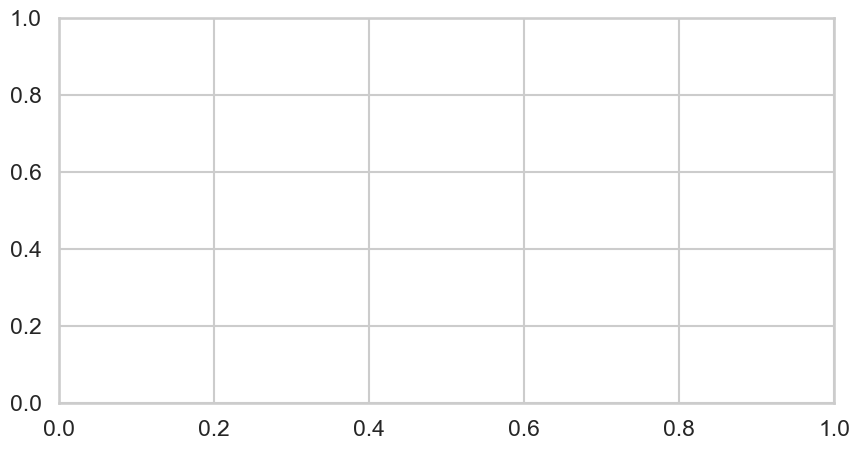

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
for fold_idx, row in val_r2_table.iterrows():
    ax.plot(row.index, row.values, '-x', c='black', alpha=.3, label="single fold" if fold_idx is 0 else None)
# plt.plot(row.index, val_r2_table.mean(axis=0), c='white', linewidth=5)
ax.plot(row.index, val_r2_table.mean(axis=0), label='Mean')
ax.legend()
ax.set(xlabel="n_neighbors", ylabel="$R^2$ on validation fold", title="Performance vs hyperparameter over different CV folds");

NameError: name 'val_r2_table' is not defined

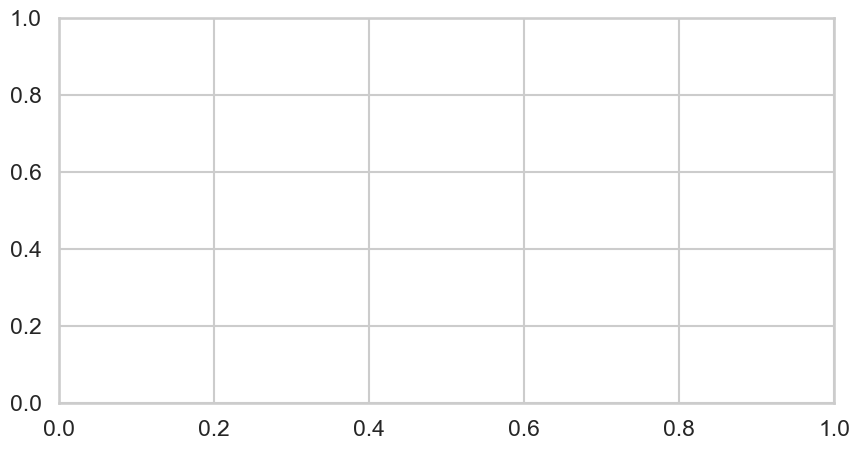

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(val_r2_table.values, positions=k_vals, widths=4);
ax.set(xlabel="n_neighbors", ylabel="$R^2$ on validation fold");

In [30]:
cv_r2_mean = cv_results.groupby('n_neighbors').val_r2.mean()
cv_r2_std = cv_results.groupby('n_neighbors').val_r2.std()
plt.errorbar(k_vals, cv_r2_mean, yerr=cv_r2_std, capsize=5)
plt.gca().set(xlabel="n_neighbors", ylabel="Validation $R^2$ $\pm$ stdev");

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/m_/f7m4q3pj7j3f6tby_sb7n5280000gn/T/ipykernel_5538/2722473538.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.gca().set(xlabel="n_neighbors", ylabel="Validation $R^2$ $\pm$ stdev");
/var/folders/m_/f7m4q3pj7j3f6tby_sb7n5280000gn/T/ipykernel_5538/2722473538.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.gca().set(xlabel="n_neighbors", ylabel="Validation $R^2$ $\pm$ stdev");


NameError: name 'cv_results' is not defined

# Make a final model with our optimal hyperparameter value

For now, let's use the model with the best mean CV performance.

In [31]:
best_n_neighbors = cv_r2_mean.idxmax()
estimated_r2_best = cv_r2_mean[best_n_neighbors]
print("The best n_neighbors is {}, with estimated R^2 = {:.2f} +- {:.2f}".format(
      best_n_neighbors, estimated_r2_best, cv_r2_std[best_n_neighbors]))

NameError: name 'cv_r2_mean' is not defined

In [32]:
all_my_data = pd.concat([train, valid])
my_best_model = (
    KNeighborsRegressor(n_neighbors=best_n_neighbors)
    .fit(all_my_data[all_predictors], all_my_data.Fare_amount))
assert len(train) + len(valid) == len(all_my_data)
print(f"Trained a new model on {len(train)} + {len(valid)} = {len(all_my_data)} samples.")

NameError: name 'valid' is not defined

# How well does this model perform on unseen data?

We've already looked at train and validation. Only test remains completely unseen. The point of no return...

In [1]:
test_predictions = my_best_model.predict(test[all_predictors])
test_r2 = metrics.r2_score(test.Fare_amount, test_predictions)
print(f"Our best model got an R^2 of {test_r2:.3f}.")

NameError: name 'my_best_model' is not defined

# Same approach works for penalized regression

In [1]:
def cross_validate_general(train_model, X, y, n_splits, params):
    cv_results = []
    cv = KFold(n_splits=n_splits)
    
    # Outer loop: pick hyperparameter setting.
    for param_setting in params:
        
        # Inner loop: pick train and validation sets.
        for fold_idx, (train_indices, valid_indices) in enumerate(cv.split(X, y)):
            # Train on training set.
            model = train_model(X[train_indices], y[train_indices], param_setting)

            # Evaluate on validation set.
            val_predictions = model.predict(X[valid_indices])
            val_r2 = metrics.r2_score(y[valid_indices], val_predictions)
            val_mse = metrics.mean_squared_error(y[valid_indices], val_predictions)

            cv_results.append(dict(
                param_setting,
                fold_idx=fold_idx,
                val_r2=val_r2,
                val_mse=val_mse
            ))
    return pd.DataFrame(cv_results)

def train_lasso(X, y, params):
    return Lasso(alpha=params['alpha']).fit(X, y)
    
def train_KNN(X, y, params):
    return KNeighborsRegressor(n_neighbors=params['n_neighbors']).fit(X, y)

In [2]:
X = train[all_predictors].values
y = train.Fare_amount.values

params = [{'alpha': alpha} for alpha in [.001, .01, .1, 1., 10.]]
cv_results = cross_validate_general(
    train_model=train_lasso,
#     train_model=train_KNN,
    X=X, y=y,
    n_splits=10, params=params)

agg_cv_results = cv_results.groupby('alpha').val_r2.agg(['mean', 'std'])
agg_cv_results

NameError: name 'train' is not defined

In [3]:
best_alpha = agg_cv_results['mean'].idxmax()
estimated_r2 = agg_cv_results['mean'][best_alpha]
best_model = Lasso(alpha=best_alpha).fit(X, y)
test_predictions = best_model.predict(test[all_predictors].values)
test_r2 = metrics.r2_score(test.Fare_amount, test_predictions)
print(f"Best alpha was {best_alpha}, with estimated R^2 of {estimated_r2:.3f}.")
print(f"Training this on all data gives a test R^2 of {test_r2:.3f}")

NameError: name 'agg_cv_results' is not defined

In [4]:
# We could also use a meta-estimator from sklearn.
# But make sure you understand all of what's going on in the above first!
from sklearn.model_selection import GridSearchCV

gridsearch_model = GridSearchCV(
    estimator=Lasso(),
    param_grid=[{'alpha': [.1, 1., 10.]}],
    cv=KFold(n_splits=10),
    scoring='r2',
    return_train_score=False)
gridsearch_model.fit(X, y)
pd.DataFrame(gridsearch_model.cv_results_).set_index('param_alpha')


NameError: name 'Lasso' is not defined